In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Some Reference
https://www.kaggle.com/eikedehling/tune-and-compare-xgb-lightgbm-rf-with-hyperopt
http://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

# Dataset loading

In [2]:
dataset = pd.read_csv('../Y3 - Sample data/Z2 - datasetprepclean.csv', index_col = 0,
                     )
print('dataset shape:', dataset.shape)
dataset.head()

dataset shape: (5401, 665)


,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,minimum_rectangle_dim2,convex_hull_area,no_hole_area,thickness,...,bendlength_bend_edge_length_min_04,bendlength_bend_edge_length_max_04,weight,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group
COART,,,,,,,,,,,,,,,,,,,,,
L1600360,3178.489502,9,0,285678.093750,431798.46875,722.070984,598.000000,320484.593750,286893.718750,4.0,...,29.010676,594.972659,13.273485,12.51,5.15,17.66,0.000010,0.000007,0.000011,3-5
L1600470,317.114502,1,0,3403.138184,3500.00000,140.000000,25.000000,3403.138184,3403.138184,10.0,...,0.000000,0.000000,0.268975,0.25,0.92,1.17,0.000007,0.000007,0.000007,0
L1600600,3710.627930,1,0,522587.812500,522587.81250,1509.000000,346.313995,522587.812500,522587.812500,3.0,...,0.000000,0.000000,12.048263,18.36,7.55,25.91,0.000012,0.000012,0.000012,1-2
L1600610,3232.627930,1,0,439818.781250,439818.78125,1270.000000,346.313995,439818.781250,439818.781250,3.0,...,0.000000,0.000000,10.140022,9.18,4.77,13.95,0.000007,0.000007,0.000007,1-2
L1600620,2972.627930,1,0,394797.968750,394797.96875,1140.000000,346.313995,394797.968750,394797.968750,3.0,...,0.000000,0.000000,9.102067,9.18,4.65,13.83,0.000008,0.000008,0.000008,1-2


In [3]:
dataset.columns.values

array(['cut_length', 'num_closed_patterns', 'num_open_patterns',
       'total_area', 'minimum_rectangle_area', 'minimum_rectangle_dim1',
       'minimum_rectangle_dim2', 'convex_hull_area', 'no_hole_area',
       'thickness', 'radius_approx', 'radius_count', 'direction_count',
       'bend_count', 'benddxf_bend_radius_00', 'benddxf_bend_angle_00',
       'benddxf_bend_direction_00', 'benddxf_deformation_length_00',
       'benddxf_merged_bend_00', 'benddxf_punch_length_00',
       'benddxf_bend_radius_01', 'benddxf_bend_angle_01',
       'benddxf_bend_direction_01', 'benddxf_deformation_length_01',
       'benddxf_merged_bend_01', 'benddxf_punch_length_01',
       'benddxf_bend_radius_02', 'benddxf_bend_angle_02',
       'benddxf_bend_direction_02', 'benddxf_deformation_length_02',
       'benddxf_merged_bend_02', 'benddxf_punch_length_02',
       'benddxf_bend_radius_03', 'benddxf_bend_angle_03',
       'benddxf_bend_direction_03', 'benddxf_deformation_length_03',
       'benddxf_mer

In [4]:
for index, nancount in dataset.isnull().sum().iteritems():
    if nancount != 0:
        print(index, '-->', nancount)
else:
    print('Done !')

dataset.shape

benddxf_deformation_length_00 --> 262
benddxf_deformation_length_01 --> 123
benddxf_deformation_length_02 --> 19
benddxf_deformation_length_03 --> 6
benddxf_deformation_length_04 --> 1
benddxf_deformation_length_05 --> 1
bendlength_deformation_length_00 --> 296
bendlength_deformation_length_01 --> 112
bendlength_deformation_length_02 --> 3
bendlength_deformation_length_03 --> 1
Done !


(5401, 665)

In [5]:
#Cleaning of the remaining Nan

subset = [x for x in dataset.columns.values if x.startswith('benddxf_')]

#dataset = dataset.fillna(0)
dataset = dataset.dropna(subset=subset)
dataset.shape

(5105, 665)

# cleaning to have at least min occurences

In [6]:
minocc = 50
todrop = []
df = dataset['thickness'].reset_index().groupby('thickness').count()
for index, occ in df.iterrows():
    if occ.COART <= minocc:
        print(occ.COART)
        todrop.append(index)
        print(index, 'will be dropped')

for thickness in todrop:
    dataset = dataset[dataset['thickness'] != thickness]

dataset.shape

33
1.5 will be dropped
1
2.5 will be dropped
6
20.0 will be dropped


(5065, 665)

# Target definition

In [7]:
target = 'VALAJOUT'
assert target in ['VAMAT', 'VALAJOUT', 'VALTOT'], 'The target must be in y dataset'

# Is the target "normal" ?

In [8]:
from scipy.stats import skew
skew(dataset[target]) #Nope !

3.1520528420901357

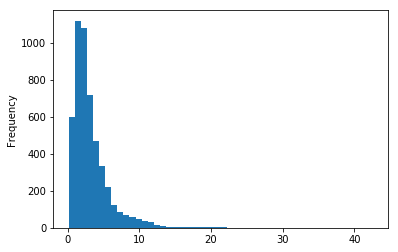

In [9]:
dataset[target].plot.hist(bins=50)
plt.show()

# Outlier tracking - VAMAT

In [10]:
toplimit = .95 #We drop the top 5%
botlimit = .02 #we drop the bottom 2%

In [11]:
#Surface cost calculation, quantile decomposition

#dataset['SURF_COST_CONVHULL'] = dataset['VAMAT'] / dataset['convex_hull_area']
dataset['SURF_COST_RECTANGLE'] = dataset['VAMAT'] / dataset['minimum_rectangle_area']
dataset['SURF_COST_MPATTERN'] = dataset['VAMAT'] / dataset['no_hole_area']
#dataset['SURF_COST_TOTAREA'] = dataset['VAMAT'] / dataset['total_area']

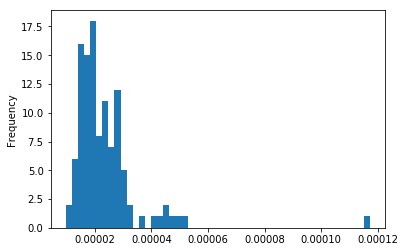

In [12]:
df = dataset[dataset['thickness'] == 2]
df['SURF_COST_MPATTERN'].plot.hist(bins=50)
plt.show()

In [13]:
#quantile decomposition
df=dataset[['thickness', 'SURF_COST_MPATTERN']].groupby('thickness').quantile([botlimit,toplimit])
df

SURF_COST_MPATTERN
thickness                         
2.0       0.02            0.000013
          0.95            0.000045
3.0       0.02            0.000018
          0.95            0.000060
4.0       0.02            0.000023
          0.95            0.000089
5.0       0.02            0.000028
          0.95            0.000091
6.0       0.02            0.000033
          0.95            0.000134
8.0       0.02            0.000044
          0.95            0.000182
10.0      0.02            0.000063
          0.95            0.000248
12.0      0.02            0.000059
          0.95            0.000247
15.0      0.02            0.000085
          0.95            0.000271

In [14]:
# If vamat is target, cleaning
if target == 'VAMAT' or target == 'VALTOT':
    for (thickness, limit), value in df.iterrows():
        tresh = value.values[0]
        if limit == botlimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(5065, 667)

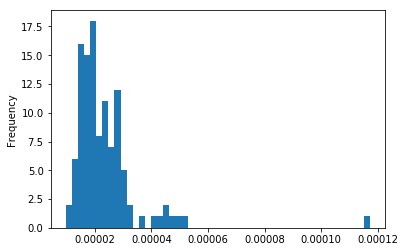

In [15]:
df = dataset[dataset['thickness'] == 2]
df['SURF_COST_MPATTERN'].plot.hist(bins=50)
plt.show()

In [16]:
skew(dataset[target])

3.1520528420901357

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


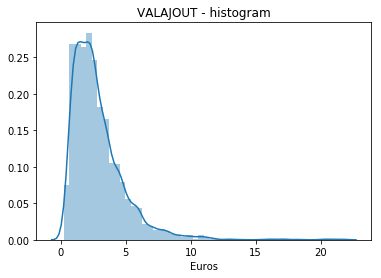

In [96]:
sns.distplot(dataset[target],)
plt.title(f'{target} - histogram')
plt.xlabel('Euros')
plt.show()

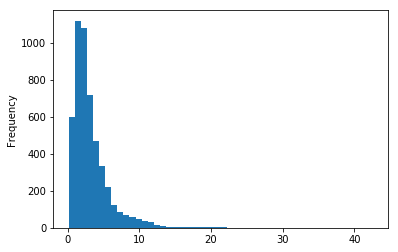

In [17]:
dataset[target].plot.hist(bins=50)
plt.show()

# Outlier tracking - VALAJOUT

In [18]:
toplimit = .95 #We drop the top 5%
botlimit = .02 #we drop the bottom 2%

In [19]:
#Cost per bend calculation

dataset['APPROX_BEND_COST'] = dataset['VALAJOUT'] / (dataset['bend_count']+1)

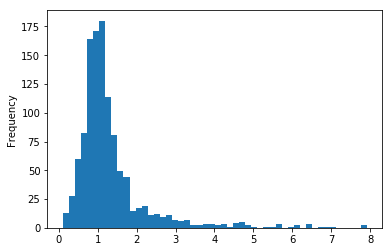

In [20]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

In [21]:
#quantile decomposition
df=dataset[['thickness', 'APPROX_BEND_COST', 'bend_count']].groupby(['thickness', 'bend_count']).quantile([botlimit,toplimit])
df

APPROX_BEND_COST
thickness bend_count                       
2.0       0          0.02          0.707200
                     0.95          7.668000
          1          0.02          0.523400
                     0.95          2.293750
          2          0.02          0.246800
                     0.95          2.151000
          3          0.02          0.624700
                     0.95          2.315000
          4          0.02          0.573280
                     0.95          2.137800
          5          0.02          0.224867
                     0.95          2.048667
          6          0.02          0.703314
                     0.95          1.496000
          7          0.02          0.700500
                     0.95          1.551500
          8          0.02          0.782978
                     0.95          2.421111
          9          0.02          0.639000
                     0.95          0.639000
          14         0.02          0.502000
                     0.95          0.502000
          20         0.02          0.759048
                     0.95          0.759048
3.0       0          0.02          0.219200
                     0.95          7.194000
          1          0.02          0.394200
                     0.95          1.532500
          2          0.02          0.405267
                     0.95          1.944833
...                                     ...
10.0      0          0.02          0.607000
                     0.95          8.637500
          1          0.02          0.971300
                     0.95          4.041250
          2          0.02          0.499267
                     0.95          3.350000
          3          0.02          0.990500
                     0.95          3.877500
          4          0.02          1.137600
                     0.95          3.032000
          5          0.02          1.855000
                     0.95          1.855000
12.0      0          0.02          0.565800
                     0.95          6.811000
          1          0.02          0.165000
                     0.95          2.292500
          2          0.02          0.716667
                     0.95          1.755333
          3          0.02          0.615000
                     0.95          1.041000
          4          0.02          0.848240
                     0.95          1.819400
15.0      0          0.02          0.691600
                     0.95          8.982000
          1          0.02          1.100000
                     0.95          2.962250
          2          0.02          0.853333
                     0.95          1.725000
          3          0.02          0.870000
                     0.95          1.795000

[150 rows x 1 columns]

In [22]:
# If VALAJOUT is target, cleaning
if target == 'VALAJOUT' or target == 'VALTOT':
    for (thickness, bend_count, limit), value in df.iterrows():
        tresh = value.values[0]
        mask1 = np.logical_and(dataset['thickness'] == thickness, dataset['bend_count'] == bend_count)
        if limit == botlimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(4651, 668)

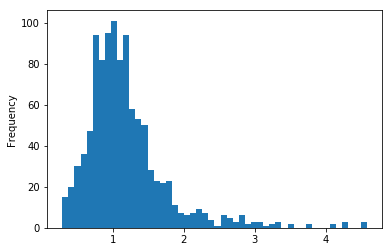

In [85]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

## Target review

In [24]:
#Dataset definition
X = dataset
y = dataset[['VAMAT', 'VALAJOUT', 'VALTOT']]

,VALAJOUT
count,4651.000000
mean,2.864863
std,2.096624
min,0.220000
25%,1.480000
50%,2.370000
75%,3.620000
max,21.790000


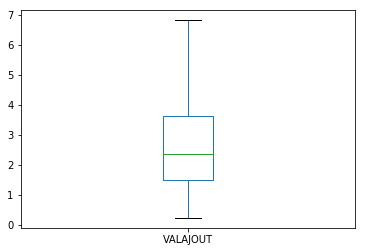

In [25]:
y[[target]].plot.box(sym='')
y[[target]].describe()

# Dataset re-ordering and Splitting

In [26]:
limitedset = ['cut_length', 'num_closed_patterns', 'num_open_patterns', 'total_area', 'minimum_rectangle_area',
              'minimum_rectangle_dim1', 'minimum_rectangle_dim2', 'convex_hull_area', 'no_hole_area', 'weight']

# 1 Bend as a float
limitedset.append('thickness')

# 2 Thickness as categories
#limitedset.extend([x for x in dataset.columns.values if x.startswith('thick_')])

# 3 Different counts
limitedset.extend(['radius_count', 'direction_count', 'bend_count'])

# 4 Bends in groups
#limitedset.extend([x for x in dataset.columns.values if x.startswith('bend_gr_')])

# 5 bends according DXF
#limitedset.extend([x for x in dataset.columns.values if x.startswith('benddxf_')])

# 6 according DXF, sorted by length
if target != 'VAMAT':
    limitedset.extend([x for x in dataset.columns.values if x.startswith('bendlength_')])


print(len(limitedset))
limitedset

144


['cut_length',
 'num_closed_patterns',
 'num_open_patterns',
 'total_area',
 'minimum_rectangle_area',
 'minimum_rectangle_dim1',
 'minimum_rectangle_dim2',
 'convex_hull_area',
 'no_hole_area',
 'weight',
 'thickness',
 'radius_count',
 'direction_count',
 'bend_count',
 'bendlength_bend_radius_00',
 'bendlength_bend_angle_00',
 'bendlength_bend_direction_00',
 'bendlength_deformation_length_00',
 'bendlength_merged_bend_00',
 'bendlength_punch_length_00',
 'bendlength_bend_radius_01',
 'bendlength_bend_angle_01',
 'bendlength_bend_direction_01',
 'bendlength_deformation_length_01',
 'bendlength_merged_bend_01',
 'bendlength_punch_length_01',
 'bendlength_bend_radius_02',
 'bendlength_bend_angle_02',
 'bendlength_bend_direction_02',
 'bendlength_deformation_length_02',
 'bendlength_merged_bend_02',
 'bendlength_punch_length_02',
 'bendlength_bend_radius_03',
 'bendlength_bend_angle_03',
 'bendlength_bend_direction_03',
 'bendlength_deformation_length_03',
 'bendlength_merged_bend_03',

In [27]:
# Dataset splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0 ,stratify=dataset['bend_group'])

print(X_train.shape, X_test.shape)

#ONLY FOR DATASET CLEANING PURPOSE
#X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.5, random_state=0 ,stratify=dataset['bend_group'])

(3255, 668) (1396, 668)


# Box_cox feature creation

In [28]:
from scipy import stats
from scipy.special import inv_boxcox
_, lmbda = stats.boxcox(y_train[target], lmbda=None)
y_train['logtarget'] = y_train[target].apply(lambda x: stats.boxcox(x, lmbda))
y_test['logtarget'] = y_test[target].apply(lambda x: stats.boxcox(x, lmbda))

/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Blocs creation

In [29]:
#Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [30]:
# Metric MSE
from sklearn.metrics import mean_squared_error

In [31]:
# Metric MAE
from sklearn.metrics import mean_absolute_error

In [32]:
# Metric MAPE Mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import make_scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
mape_scorer

make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [33]:
#regressions
import lightgbm as lgb

gbm = lgb.LGBMRegressor(objective='regression',
                        n_estimators=200,
                        random_state=0,
                       )

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [35]:
#Pipe definition
pipe = [('scaler', scaler), ('gbm', gbm)]

# Direct prediction

In [36]:
regpip = Pipeline(pipe)

In [37]:
regpip.fit(X_train[limitedset], y_train[target])

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=0,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))])

In [38]:
param_grid = {
    'gbm__num_leaves':[20, 30, 40],
    #'gbm__min_child_weight':np.logspace(-3,1,5),
    'gbm__min_data_in_leaf':[20,30,10],
    
    }

#MSE version
gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_squared_error', verbose=5)

#gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring={'mse':'neg_mean_squared_error', 'mape':mape_scorer}, verbose=5, refit='mse')


#MAPE version
#gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring=mape_scorer, verbose=2)

In [39]:
gridgbm.fit(X_train[limitedset], y_train[target])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=20 ....................
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=20 ....................
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=20 ....................
[CV]  gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.6951224237910578, total=   1.9s
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=30 ....................
[CV]  gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.6940365981407637, total=   2.4s
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=30 ....................
[CV]  gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.6539019081278936, total=   3.2s
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=30 ....................
[CV]  gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.7070577438700897, total=   3.4s
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=40 ....................
[CV]  gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.6794372229

[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:   14.9s


[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.7086283550838001, total=   2.6s
[CV] gbm__min_data_in_leaf=30, gbm__num_leaves=40 ....................
[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.7158231319776228, total=   3.3s
[CV] gbm__min_data_in_leaf=30, gbm__num_leaves=40 ....................
[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.6829416245695936, total=   3.2s
[CV] gbm__min_data_in_leaf=30, gbm__num_leaves=40 ....................
[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.6625733241776687, total=   4.4s
[CV] gbm__min_data_in_leaf=10, gbm__num_leaves=20 ....................
[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.7362064714630535, total=   4.2s
[CV] gbm__min_data_in_leaf=10, gbm__num_leaves=20 ....................
[CV]  gbm__min_data_in_leaf=10, gbm__num_leaves=20, score=-0.7021058220745775, total=   1.9s
[CV] gbm__min_data_in_leaf=10, gbm__num_leaves=20 ....................
[CV]  gbm__min_d

[Parallel(n_jobs=-2)]: Done  27 out of  27 | elapsed:   31.7s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_spli...0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'gbm__num_leaves': [20, 30, 40], 'gbm__min_data_in_leaf': [20, 30, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=5)

In [40]:
print('target        :', target)
print('best score    :', gridgbm.best_score_)
print('best params   :', gridgbm.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], gridgbm.predict(X_test[limitedset]))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], gridgbm.predict(X_test[limitedset]))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], gridgbm.predict(X_train[limitedset]))
print('MSE train set :', msetrain)


target        : VALAJOUT
best score    : -0.6611921330184108
best params   : {'gbm__min_data_in_leaf': 10, 'gbm__num_leaves': 20}
MAPE test set : 20.659834320981048
MSE  test set : 0.6454464690440753
MSE train set : 0.1301035219739939


## Hyperopt

In [41]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score

In [42]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'min_data_in_leaf': int(params['min_data_in_leaf']),
        'min_child_weight': params['min_child_weight'],
        #'n_estimators': int(params['n_estimators']),
        'colsample_bytree': params['colsample_bytree'],
        'bagging_fraction': params['bagging_fraction'],
        'bagging_freq': params['bagging_freq'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'max_depth':int(params['max_depth']),
        'learning_rate':params['learning_rate'],
        }
    
    clf = lgb.LGBMRegressor(objective='regression', n_estimators=200, **params)

    pipe = [('scaler', scaler), ('xgb', clf)]
    regpip = Pipeline(pipe)    
    
    score = cross_val_score(regpip, X_train[limitedset], y_train[target], scoring='neg_mean_squared_error', cv=3, n_jobs=-2).mean()
    print("MSE {:.3f} - params {}".format(score, params))
    return -score

space = {
    'num_leaves': hp.uniform('num_leaves', 5, 40),
    'min_data_in_leaf': hp.uniform('min_data_in_leaf',10, 40),
    'min_child_weight': hp.uniform('min_child_weight', 0.001, 20),
    #'n_estimators': hp.uniform('n_estimators', 100, 500),
    'colsample_bytree': hp.uniform('colsample_bytree', 0., 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0., 1.0),
    'bagging_freq': hp.randint('bagging_freq', 15),
    'reg_alpha': hp.loguniform('reg_alpha', -3, 3),
    'reg_lambda': hp.loguniform('reg_lambda', -3, 3),
    'max_depth': hp.uniform('max_depth', 3, 15),
    'learning_rate': hp.uniform('learning_rate', 0.001, .1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

MSE -0.732 - params {'num_leaves': 21, 'min_data_in_leaf': 33, 'min_child_weight': 2.3823214963946464, 'colsample_bytree': 0.3386581884306541, 'bagging_fraction': 0.6816171241478642, 'bagging_freq': 1, 'reg_alpha': 2.675525055006169, 'reg_lambda': 7.672208268014476, 'max_depth': 13, 'learning_rate': 0.059733461672670046}
MSE -1.214 - params {'num_leaves': 31, 'min_data_in_leaf': 19, 'min_child_weight': 4.581607088676251, 'colsample_bytree': 0.3334906827024344, 'bagging_fraction': 0.5175309279497813, 'bagging_freq': 14, 'reg_alpha': 6.622351660011558, 'reg_lambda': 0.12387884890779602, 'max_depth': 11, 'learning_rate': 0.007643303717980049}
MSE -0.793 - params {'num_leaves': 16, 'min_data_in_leaf': 32, 'min_child_weight': 18.04105195101889, 'colsample_bytree': 0.5620352926985012, 'bagging_fraction': 0.6386067807373594, 'bagging_freq': 4, 'reg_alpha': 0.646475230795416, 'reg_lambda': 0.09339945378915715, 'max_depth': 3, 'learning_rate': 0.037520207325545195}
MSE -0.689 - params {'num_lea

MSE -0.668 - params {'num_leaves': 11, 'min_data_in_leaf': 21, 'min_child_weight': 13.944474500736565, 'colsample_bytree': 0.8481011318808487, 'bagging_fraction': 0.12030472397494571, 'bagging_freq': 0, 'reg_alpha': 4.4684085453737765, 'reg_lambda': 5.200906054114565, 'max_depth': 5, 'learning_rate': 0.0767412027361256}
MSE -0.722 - params {'num_leaves': 18, 'min_data_in_leaf': 28, 'min_child_weight': 8.13646628194704, 'colsample_bytree': 0.19264907485135258, 'bagging_fraction': 0.6164513114964474, 'bagging_freq': 1, 'reg_alpha': 0.47281377607598607, 'reg_lambda': 0.278220907211076, 'max_depth': 7, 'learning_rate': 0.09392054409946918}
MSE -0.801 - params {'num_leaves': 22, 'min_data_in_leaf': 12, 'min_child_weight': 11.214414332234242, 'colsample_bytree': 0.7047577902238402, 'bagging_fraction': 0.3227125868962849, 'bagging_freq': 12, 'reg_alpha': 2.673776344931076, 'reg_lambda': 0.7728095362739091, 'max_depth': 3, 'learning_rate': 0.06035646812622408}
MSE -0.677 - params {'num_leaves'

In [43]:
params = {
        'num_leaves': int(best['num_leaves']),
        'min_data_in_leaf': int(best['min_data_in_leaf']),
        'min_child_weight': best['min_child_weight'],
        #'n_estimators': int(best['n_estimators']),
        'colsample_bytree': best['colsample_bytree'],
        'bagging_fraction': best['bagging_fraction'],
        'bagging_freq': best['bagging_freq'],
        'reg_alpha': best['reg_alpha'],
        'reg_lambda': best['reg_lambda'],
        'max_depth':int(best['max_depth']),
        'learning_rate':best['learning_rate'],
        }

clf = lgb.LGBMRegressor(objective='regression', n_estimators=200, **params)
pipe = [('scaler', scaler), ('gbm', clf)]
regpip = Pipeline(pipe)
regpip.fit(X_train[limitedset], y_train[target])

preds = regpip.predict(X_test[limitedset])

msetest = mean_squared_error(y_test[target], preds)
mapetest = mean_absolute_percentage_error(y_test[target], preds)
msetrain = mean_squared_error(y_train[target], regpip.predict(X_train[limitedset]))
print(target)
#print(clf.get_params())
print(params)
print('MAPE test:', mapetest)
print('MSE  test:', msetest)
print('MSE train:', msetrain)


VALAJOUT
{'num_leaves': 26, 'min_data_in_leaf': 23, 'min_child_weight': 18.49265545361246, 'colsample_bytree': 0.2541171627506255, 'bagging_fraction': 0.93808115801223, 'bagging_freq': 13, 'reg_alpha': 0.11464683543571311, 'reg_lambda': 1.1367793905102985, 'max_depth': 14, 'learning_rate': 0.056324686010016695}
MAPE test: 20.29681654871686
MSE  test: 0.6806105230821486
MSE train: 0.24662115265928394


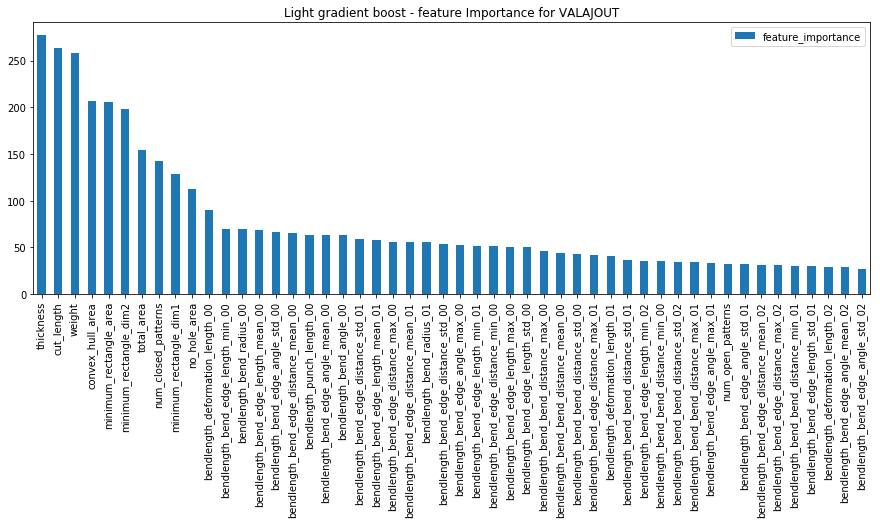

In [44]:
featimp = list(regpip.named_steps['gbm'].feature_importances_)
df = pd.DataFrame({'feature_importance':featimp}, index =limitedset)
df = df.sort_values('feature_importance', ascending=False)
df[:50].plot.bar(figsize=(15,5))
plt.title(f'Light gradient boost - feature Importance for {target}')
plt.show()

# BOX-COX prediction

In [45]:
gbmlog = lgb.LGBMRegressor(objective='regression',
                        n_estimators=200,
                        random_state=0,
                       )
pipe = [('scaler', scaler), ('gbm', gbmlog)]
regpiplog = Pipeline(pipe)

In [46]:
regpiplog.fit(X_train[limitedset], y_train['logtarget'])

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=0,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))])

In [47]:
param_grid = {
    'gbm__num_leaves':[20, 30, 40],
    'gbm__min_child_weight':np.logspace(-3,1,5),
    'gbm__min_data_in_leaf':[20,30,10],
    }

#MAE version
gridgbmlog = GridSearchCV(regpiplog, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_absolute_error', verbose=5)

#MAPE version
#gridgbmlog = GridSearchCV(regpiplog, param_grid, cv=3, n_jobs=-2, scoring=mape_scorer, verbose=2)

In [83]:
%%time
gridgbmlog.fit(X_train[limitedset], y_train['logtarget'])

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.18867327315845153, total=   1.0s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.1990953534880539, total=   2.3s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.19476804818876192, total=   3.2s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.

[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:   13.9s


[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.20080640160605853, total=   3.1s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.19625382255147486, total=   3.6s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.2021621313529457, total=   3.6s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.2013652222453714, total=   3.4s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=10, gbm__num_leaves=20 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.19586158502564371, total=   4.2s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=10, gbm__nu

[CV]  gbm__min_child_weight=0.01, gbm__min_data_in_leaf=10, gbm__num_leaves=40, score=-0.1970083341556919, total=   4.3s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.1990953534880539, total=   1.8s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.01, gbm__min_data_in_leaf=10, gbm__num_leaves=40, score=-0.19982021630863708, total=   5.6s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.19476804818876192, total=   2.9s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.19084361835240674, total=   3.3s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=40 
[CV] 

[Parallel(n_jobs=-2)]: Done  66 tasks      | elapsed:  1.3min


[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.19625382255147486, total=   2.8s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.20080640160605853, total=   3.3s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.2021621313529457, total=   4.1s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.19586158502564371, total=   4.5s
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.2013652222453714, total=   3.9s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=10, gbm__num_leaves=20 
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=10, gbm__num_leaves=20 
[CV]  g

[CV] gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV]  gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.1990953534880539, total=   2.9s
[CV] gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=1.0, gbm__min_data_in_leaf=10, gbm__num_leaves=40, score=-0.19982021630863708, total=   7.5s
[CV]  gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.19476804818876192, total=   2.7s
[CV] gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV] gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.19084361835240674, total=   3.9s
[CV] gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.1991501485009514, total=   3.7

[Parallel(n_jobs=-2)]: Done 135 out of 135 | elapsed:  2.7min finished


CPU times: user 4.31 s, sys: 397 ms, total: 4.71 s
Wall time: 2min 44s


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_spli...0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'gbm__num_leaves': [20, 30, 40], 'gbm__min_child_weight': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]), 'gbm__min_data_in_leaf': [20, 30, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=5)

In [49]:
print('target        :', target)
print('best score    :', gridgbmlog.best_score_)
print('best params   :', gridgbmlog.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], inv_boxcox(gridgbmlog.predict(X_test[limitedset]), lmbda))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], inv_boxcox(gridgbmlog.predict(X_test[limitedset]), lmbda))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], inv_boxcox(gridgbmlog.predict(X_train[limitedset]), lmbda))
print('MSE train set :', msetrain)

target        : VALAJOUT
best score    : -0.1941788916117558
best params   : {'gbm__min_child_weight': 0.001, 'gbm__min_data_in_leaf': 20, 'gbm__num_leaves': 20}
MAPE test set : 19.687684126087607
MSE  test set : 0.6261099285190476
MSE train set : 0.18949955232140686


In [50]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'min_data_in_leaf': int(params['min_data_in_leaf']),
        'min_child_weight': params['min_child_weight'],
        #'n_estimators': int(params['n_estimators']),
        'colsample_bytree': params['colsample_bytree'],
        'bagging_fraction': params['bagging_fraction'],
        'bagging_freq': params['bagging_freq'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'max_depth':int(params['max_depth']),
        'learning_rate':params['learning_rate'],
        }
    
    clf = lgb.LGBMRegressor(objective='regression', n_estimators=200, **params)

    pipe = [('scaler', scaler), ('gbm', clf)]
    regpip = Pipeline(pipe)    
    
    score = cross_val_score(regpip, X_train[limitedset], y_train['logtarget'], scoring='neg_mean_absolute_error', cv=3, n_jobs=-2).mean()
    print("MSE {:.3f} - params {}".format(score, params))
    return -score

space = {
    'num_leaves': hp.uniform('num_leaves', 5, 40),
    'min_data_in_leaf': hp.uniform('min_data_in_leaf', 5, 20),
    'min_child_weight': hp.uniform('min_child_weight', 0.001, 20),
    #'n_estimators': hp.uniform('n_estimators', 100, 500),
    'colsample_bytree': hp.uniform('colsample_bytree', 0., 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0., 1.0),
    'bagging_freq': hp.randint('bagging_freq', 15),
    'reg_alpha': hp.loguniform('reg_alpha', -3, 3),
    'reg_lambda': hp.loguniform('reg_lambda', -3, 3),
    'max_depth': hp.uniform('max_depth', 3, 15),
    'learning_rate': hp.uniform('learning_rate', 0.001, .1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

MSE -0.211 - params {'num_leaves': 27, 'min_data_in_leaf': 17, 'min_child_weight': 14.131316054239544, 'colsample_bytree': 0.7792286038818407, 'bagging_fraction': 0.18155457100717887, 'bagging_freq': 4, 'reg_alpha': 0.08196545528361343, 'reg_lambda': 0.33217939030333515, 'max_depth': 14, 'learning_rate': 0.07102702413423007}
MSE -0.206 - params {'num_leaves': 34, 'min_data_in_leaf': 5, 'min_child_weight': 18.998937937416947, 'colsample_bytree': 0.23145482815350493, 'bagging_fraction': 0.3146920104476817, 'bagging_freq': 9, 'reg_alpha': 0.16407676172441252, 'reg_lambda': 0.22889760370987453, 'max_depth': 7, 'learning_rate': 0.018028724000258175}
MSE -0.207 - params {'num_leaves': 25, 'min_data_in_leaf': 8, 'min_child_weight': 3.8368395385512892, 'colsample_bytree': 0.8309192330000431, 'bagging_fraction': 0.22362099394563406, 'bagging_freq': 13, 'reg_alpha': 0.7795112004472853, 'reg_lambda': 0.48967035479852794, 'max_depth': 14, 'learning_rate': 0.03622573720571787}
MSE -0.327 - params {

MSE -0.197 - params {'num_leaves': 9, 'min_data_in_leaf': 7, 'min_child_weight': 9.472182212888912, 'colsample_bytree': 0.5040541840653554, 'bagging_fraction': 0.7354045379927455, 'bagging_freq': 2, 'reg_alpha': 4.8201491320148895, 'reg_lambda': 0.06191239269029895, 'max_depth': 13, 'learning_rate': 0.056706146301435306}
MSE -0.194 - params {'num_leaves': 16, 'min_data_in_leaf': 11, 'min_child_weight': 5.891445404396681, 'colsample_bytree': 0.3991590435626272, 'bagging_fraction': 0.8851333191910987, 'bagging_freq': 1, 'reg_alpha': 0.12317468592536113, 'reg_lambda': 0.8161003831212045, 'max_depth': 10, 'learning_rate': 0.026722223655445573}
MSE -0.231 - params {'num_leaves': 28, 'min_data_in_leaf': 6, 'min_child_weight': 14.316668150498092, 'colsample_bytree': 0.03499279527298066, 'bagging_fraction': 0.5363000394301923, 'bagging_freq': 12, 'reg_alpha': 0.10763673545566797, 'reg_lambda': 2.2796484173745344, 'max_depth': 7, 'learning_rate': 0.05954745331603706}
MSE -0.194 - params {'num_l

In [82]:
%%time
params = {
        'num_leaves': int(best['num_leaves']),
        'min_data_in_leaf': int(best['min_data_in_leaf']),
        'min_child_weight': best['min_child_weight'],
        #'n_estimators': int(best['n_estimators']),
        'colsample_bytree': best['colsample_bytree'],
        'bagging_fraction': best['bagging_fraction'],
        'bagging_freq': best['bagging_freq'],
        'reg_alpha': best['reg_alpha'],
        'reg_lambda': best['reg_lambda'],
        'max_depth':int(best['max_depth']),
        'learning_rate':best['learning_rate'],
        }

clflog = lgb.LGBMRegressor(objective='regression', n_estimators=200, **params)
pipe = [('scaler', scaler), ('gbm', clflog)]
regpiplog = Pipeline(pipe)
regpiplog.fit(X_train[limitedset], y_train['logtarget'])

preds = inv_boxcox(regpiplog.predict(X_test[limitedset]), lmbda)

msetest = mean_squared_error(y_test[target], preds)
mapetest = mean_absolute_percentage_error(y_test[target], preds)
msetrain = mean_squared_error(y_train[target], inv_boxcox(regpiplog.predict(X_train[limitedset]), lmbda))
print(target)
#print(clf.get_params())
print(params)
print('MAPE test:', mapetest)
print('MSE  test:', msetest)
print('MSE train:', msetrain)

VALAJOUT
{'num_leaves': 21, 'min_data_in_leaf': 5, 'min_child_weight': 15.805254562805027, 'colsample_bytree': 0.271685002867602, 'bagging_fraction': 0.9798389847311828, 'bagging_freq': 9, 'reg_alpha': 0.08314153876664714, 'reg_lambda': 0.6359761097010049, 'max_depth': 11, 'learning_rate': 0.03853289658038515}
MAPE test: 19.050533027117332
MSE  test: 0.6534702944455484
MSE train: 0.33901834831052363
CPU times: user 1.95 s, sys: 57.5 ms, total: 2.01 s
Wall time: 586 ms


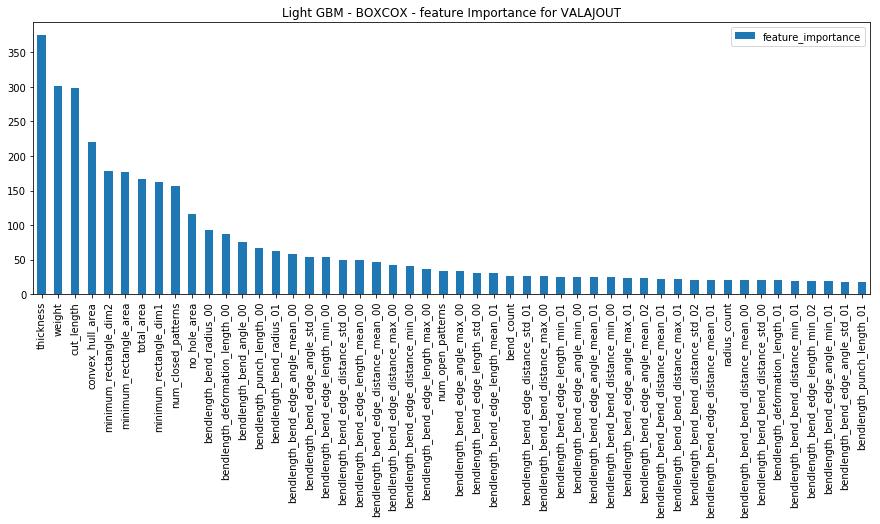

In [52]:
featimp = list(regpiplog.named_steps['gbm'].feature_importances_)
df = pd.DataFrame({'feature_importance':featimp}, index =limitedset)
df = df.sort_values('feature_importance', ascending=False)
df[:50].plot.bar(figsize=(15,5))
plt.title(f'Light GBM - BOXCOX - feature Importance for {target}')
plt.show()

# Solution comparison

In [53]:
prediction_lgbm = gridgbm.predict(X_test[limitedset])
prediction_lgbm_log = inv_boxcox(gridgbmlog.predict(X_test[limitedset]), lmbda)

In [54]:
resultset = pd.DataFrame({f'target': y_test[target],
                          'pred_lgbm':prediction_lgbm,
                          'pred_lgbm_BOXCOX':prediction_lgbm_log,
                            }, index=y_test.index)
resultset.head()

,pred_lgbm,pred_lgbm_BOXCOX,target
COART,,,
L1614870,0.961046,0.734380,1.10
L7052470,2.376176,2.388105,2.26
L7069450,4.938382,4.947808,5.16
L7056570,1.583100,1.469685,1.60
L7055980,4.422906,4.261533,4.54


In [55]:
#Solution saving
resultset.to_csv(f'{target}_pred_lgbm.csv')


In [56]:
#MAPE
mape = mean_absolute_percentage_error(resultset['target'], resultset['pred_lgbm'])
mapelog = mean_absolute_percentage_error(resultset['target'], resultset['pred_lgbm_BOXCOX'])
print('mape', mape)
print('mapelog', mapelog)

mape 20.659834320981048
mapelog 19.687684126087607


In [57]:
#MSE
mse = mean_squared_error(resultset['target'], resultset['pred_lgbm'])
mselog = mean_squared_error(resultset['target'], resultset['pred_lgbm_BOXCOX'])
print('mse', mse)
print('mselog', mselog)

mse 0.6454464690440753
mselog 0.6261099285190476


In [58]:
resultset['MSE_lgbm'] = (resultset['target']-resultset['pred_lgbm'])**2
resultset['MSE_log_lgbm'] = (resultset['target']-resultset['pred_lgbm_BOXCOX'])**2
resultset.head()

,pred_lgbm,pred_lgbm_BOXCOX,target,MSE_lgbm,MSE_log_lgbm
COART,,,,,
L1614870,0.961046,0.734380,1.10,0.019308,0.133678
L7052470,2.376176,2.388105,2.26,0.013497,0.016411
L7069450,4.938382,4.947808,5.16,0.049115,0.045026
L7056570,1.583100,1.469685,1.60,0.000286,0.016982
L7055980,4.422906,4.261533,4.54,0.013711,0.077544


In [59]:
resultset['MSE_lgbm'].mean()

0.6454464690440762

In [60]:
#Data assembly
comparisonset = pd.merge(resultset.reset_index(), X_test.reset_index(), on='COART', how='inner')
comparisonset.head()

,COART,pred_lgbm,pred_lgbm_BOXCOX,target,MSE_lgbm,MSE_log_lgbm,cut_length,num_closed_patterns,num_open_patterns,total_area,...,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group,SURF_COST_RECTANGLE,SURF_COST_MPATTERN,APPROX_BEND_COST
0,L1614870,0.961046,0.734380,1.10,0.019308,0.133678,491.239319,3,0,5183.537598,...,0.60,1.10,1.70,0.000009,0.000007,0.000014,0,0.000053,0.000109,1.100000
1,L7052470,2.376176,2.388105,2.26,0.013497,0.016411,1964.522949,5,0,56573.984375,...,4.55,2.26,6.81,0.000011,0.000006,0.000012,0,0.000036,0.000070,2.260000
2,L7069450,4.938382,4.947808,5.16,0.049115,0.045026,1373.007935,10,0,45724.308594,...,3.36,5.16,8.52,0.000010,0.000007,0.000012,6+,0.000044,0.000070,0.737143
3,L7056570,1.583100,1.469685,1.60,0.000286,0.016982,473.709930,2,0,9852.923828,...,0.30,1.60,1.90,0.000007,0.000007,0.000007,1-2,0.000029,0.000030,0.533333
4,L7055980,4.422906,4.261533,4.54,0.013711,0.077544,1868.538208,5,0,42290.605469,...,4.20,4.54,8.74,0.000011,0.000008,0.000012,3-5,0.000066,0.000097,1.135000


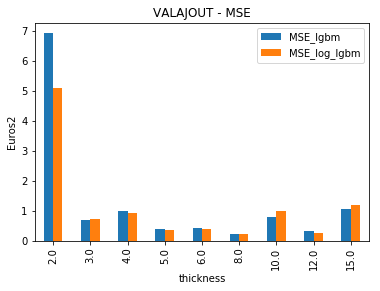

,MSE_lgbm,MSE_log_lgbm,COART
,mean,mean,count
thickness,,,
2.0,6.901780,5.083215,21
3.0,0.675473,0.730026,127
4.0,0.994848,0.924708,189
5.0,0.401411,0.356720,169
6.0,0.405799,0.375918,319
8.0,0.220588,0.208639,242
10.0,0.801432,0.990366,190
12.0,0.316228,0.258670,90


In [61]:
# Is the error sourced by thickness ?
df = comparisonset[['MSE_lgbm', 'MSE_log_lgbm', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.ylabel('Euros2')
plt.show()
comparisonset.groupby('thickness').agg({'MSE_lgbm':['mean'],
                                         'MSE_log_lgbm':['mean'],
                                         'COART':['count']})

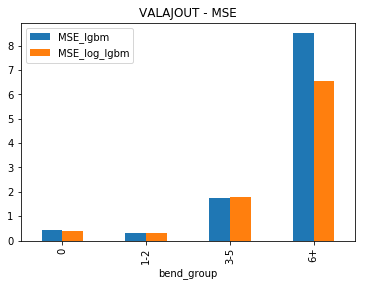

,MSE_lgbm,MSE_log_lgbm,COART
,mean,mean,count
bend_group,,,
0,0.427387,0.407560,583
1-2,0.313684,0.329362,619
3-5,1.730634,1.787550,176
6+,8.506371,6.553249,18


In [62]:
# Is the error sourced by number of bends ?

df = comparisonset[['MSE_lgbm', 'MSE_log_lgbm', 'bend_group']].groupby('bend_group').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.show()
comparisonset.groupby('bend_group').agg({'MSE_lgbm':['mean'],
                                         'MSE_log_lgbm':['mean'],
                                         'COART':['count']})

In [63]:
comparisonset['MAPE_error'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['pred_lgbm']), axis=1)
comparisonset['MAPE_log_error'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['pred_lgbm_BOXCOX']), axis=1)

comparisonset[['target', 'pred_lgbm', 'MAPE_error', 'pred_lgbm_BOXCOX', 'MAPE_log_error']].head()

,target,pred_lgbm,MAPE_error,pred_lgbm_BOXCOX,MAPE_log_error
0,1.10,0.961046,12.632220,0.734380,33.238185
1,2.26,2.376176,5.140516,2.388105,5.668356
2,5.16,4.938382,4.294931,4.947808,4.112252
3,1.60,1.583100,1.056236,1.469685,8.144695
4,4.54,4.422906,2.579158,4.261533,6.133632


In [64]:
#MAPE
comparisonset['MAPE_error'].mean()

20.65983432098105

In [65]:
#If bends use this line
if target == 'VALAJOUT' or target == 'VALTOT':
    df = comparisonset[['MSE_lgbm', 'MSE_log_lgbm','MAPE_error', 'MAPE_log_error', 'thickness', 'bend_group', 'COART']].groupby(['thickness', 'bend_group'])

#If no bends use this line
if target == 'VAMAT':
    df = comparisonset[['MSE_lgbm', 'MSE_log_lgbm','MAPE_error', 'MAPE_log_error', 'thickness', 'COART']].groupby(['thickness'])

perf = df.agg({'MSE_lgbm': ['mean', 'max'],
        'MSE_log_lgbm': ['mean', 'max'],
        'MAPE_error': ['mean', 'max'],
        'MAPE_log_error': ['mean', 'max'],
        'COART':['count'] })
perf

MSE_lgbm            MSE_log_lgbm            MAPE_error  \
                           mean        max         mean        max       mean   
thickness bend_group                                                            
2.0       0            0.495746   0.538109     0.121467   0.180310  80.856136   
          1-2          1.159266   5.650203     0.897994   5.081762  31.659371   
          3-5          4.586682  20.831259     3.155777   9.541818  18.187262   
          6+          25.641248  84.074207    19.307548  72.591456  52.108125   
3.0       0            0.460230   4.167235     0.333737   2.912972  34.170874   
          1-2          0.150787   1.160288     0.161282   1.232598  13.231418   
          3-5          1.212935   9.874148     1.622847  10.547869  16.924732   
          6+           3.575578  13.181312     2.653606   5.137605   9.159832   
4.0       0            0.349236   3.067888     0.319027   3.566707  34.358531   
          1-2          0.201526   1.453168     0.252255   2.698193  18.583788   
          3-5          3.385805  53.765701     3.005632  46.391762  26.727856   
          6+           2.974530   5.493978     2.256590   4.511183  23.375769   
5.0       0            0.270149   2.508277     0.209365   2.091860  42.443934   
          1-2          0.232361   2.933805     0.222990   2.436242  14.357504   
          3-5          0.391239   3.092475     0.523374   6.179876  10.929403   
          6+           4.498655  14.786110     2.975931  10.132644  12.702644   
6.0       0            0.284602  12.624442     0.266690  13.146582  27.488964   
          1-2          0.384957  12.726106     0.333920   8.226357  15.232733   
          3-5          0.964788   3.850903     0.860267   4.229893  22.554229   
          6+           2.114725   4.180335     4.033714   8.022402  13.187351   
8.0       0            0.201162   3.301705     0.157780   3.296785  18.915526   
          1-2          0.198883   3.660286     0.185532   3.924781  10.539962   
          3-5          0.436413   4.451369     0.605112   9.135813   8.973047   
10.0      0            0.775547  11.801492     0.794382  13.399604  20.770698   
          1-2          0.517951  10.421310     0.731199  10.495259   9.760710   
          3-5          5.623135  20.510893     9.189503  30.283032  16.342558   
12.0      0            0.208303   1.891788     0.166876   1.632668  25.222825   
          1-2          0.546051   3.950609     0.498450   3.318324  64.636226   
          3-5          1.815617   1.815617     0.470547   0.470547  36.815525   
15.0      0            1.177523  10.144672     1.316206  13.128182  19.403444   
          1-2          0.373102   2.065789     0.492268   2.621517  12.934148   
          3-5          0.001010   0.001010     0.264439   0.264439   0.628119   

                                 MAPE_log_error             COART  
                             max           mean         max count  
thickness bend_group                                               
2.0       0            84.317169      38.785990   48.807950     2  
          1-2          97.021044      25.229949   92.011278     8  
          3-5          43.139201      16.410436   33.358352     7  
          6+          142.378864      37.376618  132.299099     4  
3.0       0           200.534647      29.782871  160.776365    33  
          1-2          87.574507      14.196163   90.262131    52  
          3-5         111.569325      19.666105  105.244322    37  
          6+           22.273667      10.288275   13.905696     5  
4.0       0           130.293665      25.055995   82.182695    29  
          1-2         211.486729      19.222231  184.315299   114  
          3-5          91.028384      24.652534   91.207648    44  
          6+           34.418850      16.002772   31.188761     2  
5.0       0           248.138174      38.636498  222.330924    57  
          1-2          77.987873      14.734745   72.028713    75  
          3-5          67.63628

In [66]:
perf.loc[2.]['MSE_lgbm', 'mean']


bend_group
0       0.495746
1-2     1.159266
3-5     4.586682
6+     25.641248
Name: (MSE_lgbm, mean), dtype: float64

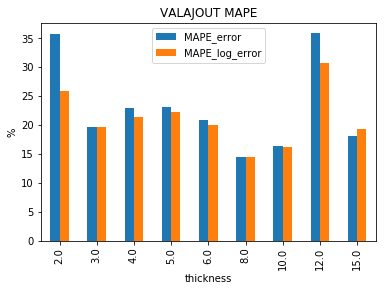

,MAPE_error,MAPE_log_error,COART
,mean,mean,count
thickness,,,
2.0,35.749075,25.894814,21
3.0,19.588085,19.686004,127
4.0,22.950934,21.347488,189
5.0,23.132374,22.293217,169
6.0,20.857251,19.929000,319
8.0,14.418723,14.392675,242
10.0,16.308120,16.243856,190
12.0,35.861873,30.718436,90


In [67]:
df = comparisonset[['MAPE_error', 'MAPE_log_error', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} MAPE')
plt.ylabel('%')
plt.show()
comparisonset.groupby('thickness').agg({'MAPE_error':['mean'],
                                         'MAPE_log_error':['mean'],
                                         'COART':['count']})

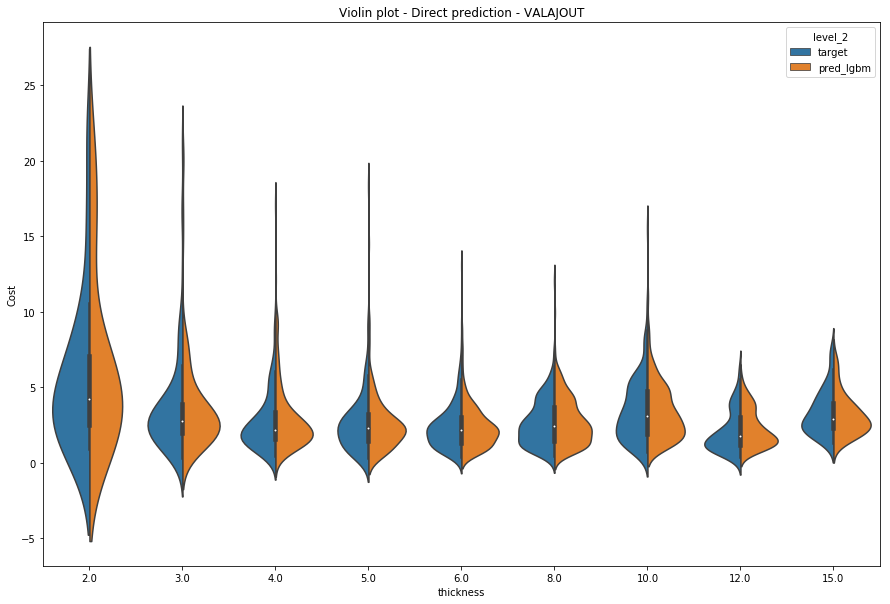

In [68]:
#Violin plot
df=comparisonset[['target', 'pred_lgbm', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
#ax.set_ylim(-100, 100)
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)
plt.title(f'Violin plot - Direct prediction - {target}')
plt.ylabel('Cost')
plt.show()

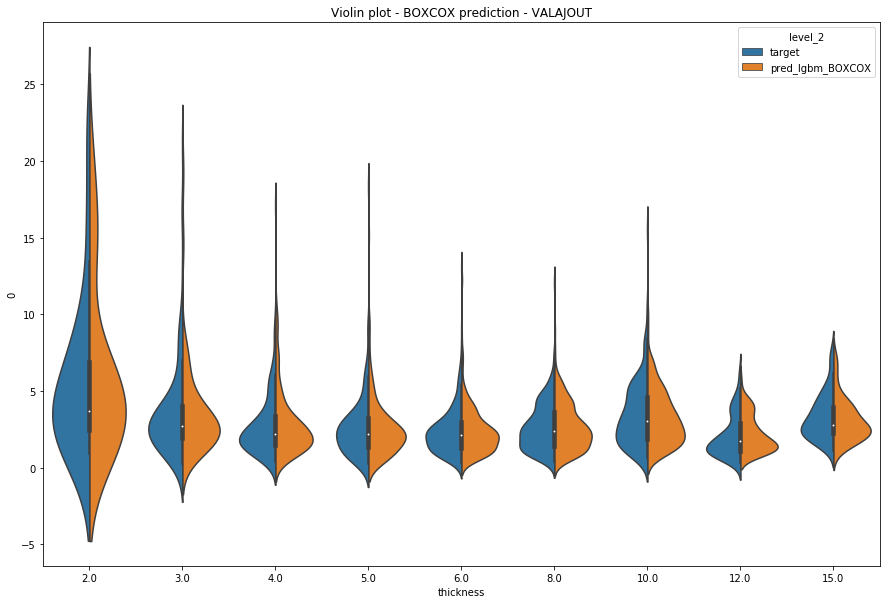

In [69]:
#Violin plot
df=comparisonset[['target', 'pred_lgbm_BOXCOX', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)
plt.title(f'Violin plot - BOXCOX prediction - {target}')
plt.show()

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


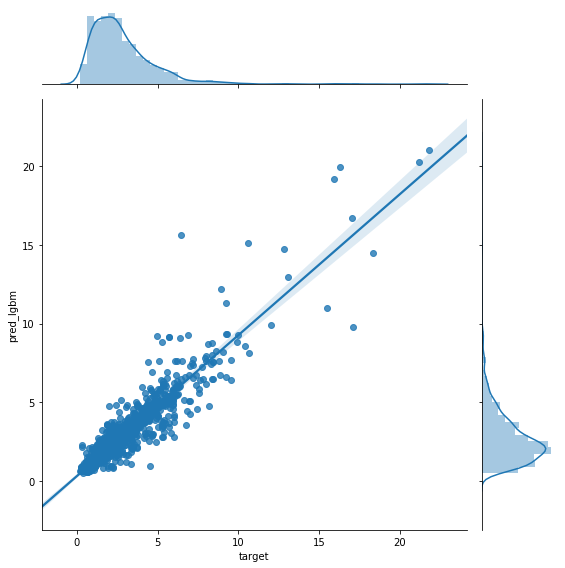

In [70]:
# No BOXCOX
sns.jointplot(x='target', y='pred_lgbm', data=comparisonset, kind='reg', size=8, stat_func=None)
plt.show()

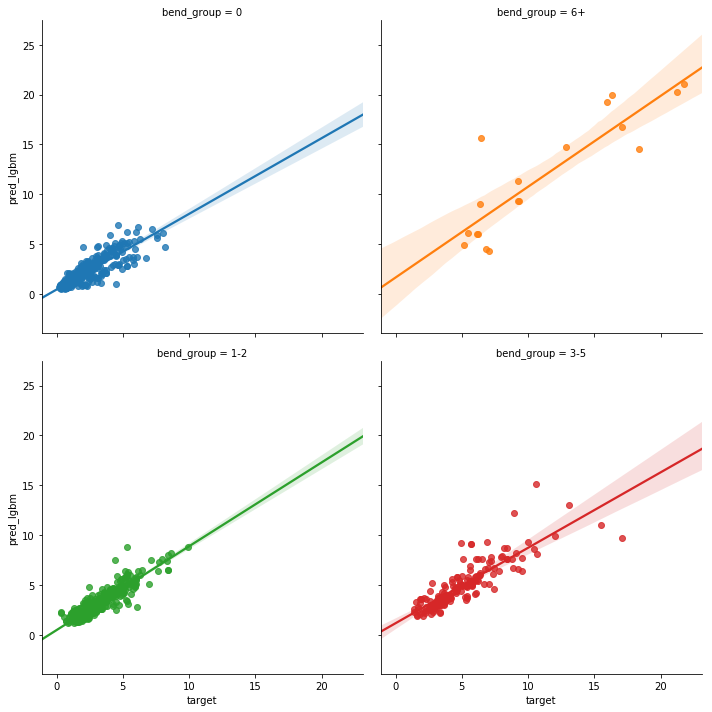

In [71]:
sns.lmplot(x='target',
           y='pred_lgbm',
           col='bend_group',
           hue='bend_group',
           data=comparisonset,
           aspect=1,
           col_wrap=2,
           size=5,
           legend=True)
plt.show()

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


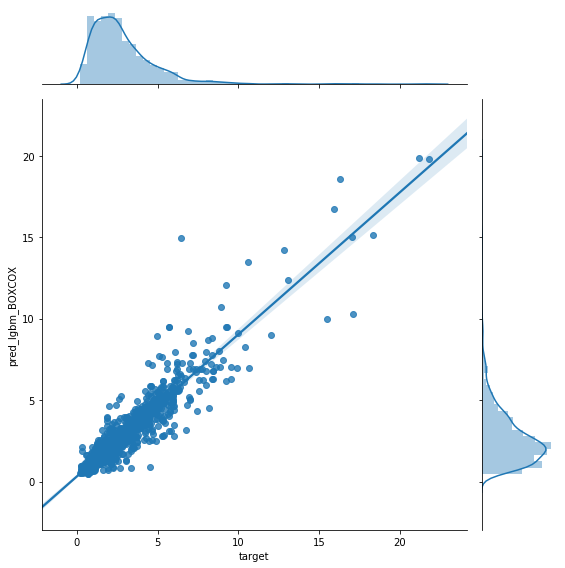

In [72]:
# With BOXCOX
sns.jointplot(x='target', y='pred_lgbm_BOXCOX', data=comparisonset, kind='reg',size=8, stat_func=None)
plt.show()

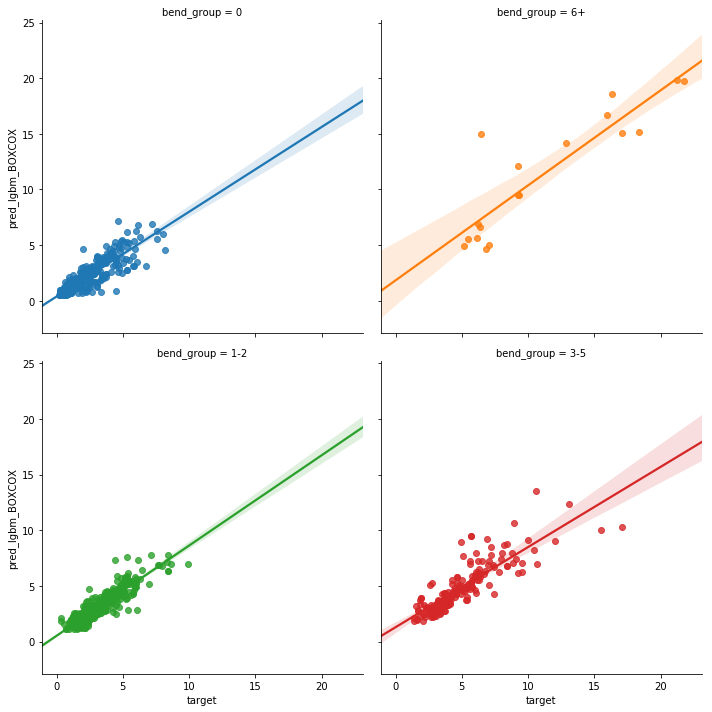

In [73]:
sns.lmplot(x='target',
           y='pred_lgbm_BOXCOX',
           col='bend_group',
           hue='bend_group',
           data=comparisonset,
           aspect=1,
           col_wrap=2,
           size=5,
           #palette="Set1",
           legend=True),
plt.show()

In [74]:
df = comparisonset[['MSE_lgbm', 'COART', 'thickness']]
df.set_index('COART', inplace=True)
worst = df.groupby('thickness')['MSE_lgbm'].nlargest(5)

#worst.to_csv(f'../Y3 - Sample data/Z3 - {target}-outliers.csv')
print(worst.shape)
worst

(45,)


thickness  COART   
2.0        L7067210    84.074207
           L2503310    20.831259
           L5701460    10.692723
           L3103920     7.220246
           L6019240     7.001324
3.0        L3111900    13.181312
           L2513140     9.874148
           L6703390     8.198780
           L6006340     4.167235
           L3103530     3.686197
4.0        L8838710    53.765701
           L6703410    17.969054
           L8815170    11.896467
           L8815160    11.758902
           L1608630    10.446765
5.0        L7065870    14.786110
           L8828280     7.680231
           L3100190     3.092475
           L6010520     2.933805
           L8833050     2.646028
6.0        L8035050    12.726106
           L2611660    12.624442
           L8035060     9.826149
           L3107181     4.180335
           L8834390     3.850903
8.0        L7059600     4.451369
           L7034960     3.660286
           L2522320     3.301705
           L2608230     3.040611
           L7080990    

In [75]:
comparisonset['delta_log'] = comparisonset['target'] - comparisonset['pred_lgbm_BOXCOX']


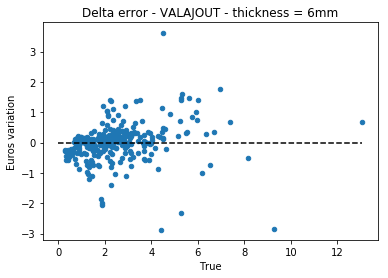

,delta_log
count,319.000000
mean,0.018651
std,0.613801
min,-2.868163
25%,-0.201644
50%,0.057594
75%,0.223208
max,3.625822


In [76]:

thickness = 6

df = comparisonset[comparisonset['thickness']==thickness]

df.plot.scatter('target', 'delta_log')
plt.plot([0, df['target'].max()], [0, 0], color='k', linestyle='--')
plt.title('Delta error - {} - thickness = {}mm'.format(target, thickness))
plt.xlabel('True')
plt.ylabel('Euros variation')
plt.show()
df[['delta_log']].describe()

In [77]:
comparisonset[['COART', 'pred_lgbm_BOXCOX', 'target', 'thickness', 'bend_group']].to_csv(f'../Y3 - Sample data/Z4 - {target}-predictions.csv')

In [78]:
df.shape
#df[['delta_log', 'target', 'pred_lgbm_BOXCOX']]

(319, 677)

In [79]:
#comparison

#Thickness filter
df = comparisonset[comparisonset['thickness'] == 8]

#Cost filter Max
#df = df[df[target]<15]

#Cost filter Min
#df = df[df[target]>10] #bend_count

#Min rectangle area
#df = df[df['minimum_rectangle_area'] < 700000]
df = df[df['minimum_rectangle_area'] > 10000]

#bend_count filter
df = df[df['bend_count'] == 4]

#df[df['COART']=='L3128890'].T
df.T

,479,626,725,1232
COART,L2521660,L7059600,L3070880,L6014840
pred_lgbm,5.01914,9.94017,5.42075,4.93278
pred_lgbm_BOXCOX,5.22375,9.02745,5.30497,4.83275
target,5.7,12.05,5.64,5.31
MSE_lgbm,0.463575,4.45137,0.0480696,0.142293
MSE_log_lgbm,0.226812,9.13581,0.112244,0.227771
cut_length,2247.99,4581.36,2099.71,1797.27
num_closed_patterns,13,14,3,3
num_open_patterns,0,0,0,0
total_area,95965.2,357132,54361.4,89761.7


In [80]:
dataset.loc[['L8835850']].T
#comparisonset[comparisonset['COART'] == 'L3131690']

COART,L8835850
cut_length,6989.19
num_closed_patterns,19
num_open_patterns,0
total_area,196112
minimum_rectangle_area,626653
minimum_rectangle_dim1,1322.67
minimum_rectangle_dim2,473.779
convex_hull_area,530068
no_hole_area,221461
thickness,8
